<a href="https://colab.research.google.com/github/victorasso/Bosch_Kaggle/blob/master/notebooks/011-lv-dataset-builder-wikipedia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ajax Crawler

Crawl the GUI for yearly trends information, this pipeline is able to get a list of queries and return a temporal dataframe with the following content types:

* Patents
* Papers
* Projects
* Grants

In [100]:
from google.colab import drive
drive.mount('/content/drive')
!rm -rf sample_data

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [101]:
import json
import glob
import requests
import numpy as np
import pandas as pd
from tqdm import tqdm
from random import sample
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# Helper functions

All custom functions used in this notebook are located here

In [181]:
#take content_type from col
def take_content_type(s):
  return s.split(' ')[0]

#take search_type from col
def take_search_type(s):
  return ' '.join(s.split(' ')[1:])

# get GUI auth token
def get_auth_token(user, password):
  url = "https://app.wheesbee.eu/api/w2/jwt/login.ajax"

  payload = json.dumps({
    "username": user,
    "password": password
  })
  headers = {
    'Content-Type': 'application/json'
  }

  response = requests.request("POST", url, headers = headers, data = payload)
  #print(response.text)
  token = response.json()['token']

  return token

# get query count by year dataframe
def get_query_count_by_year(query, content_type, token):

  url = f"https://app.wheesbee.eu/api/w2/analysis/{content_type}/trend.ajax"

  payload = json.dumps({
    "term": query
  })
  headers = {
    'Authorization': f'Bearer {token}',
    'Content-Type': 'application/json'
  }

  response = requests.request("POST", url, headers = headers, data = payload)

  # unpack json to dataframe
  df = pd.DataFrame(response.json()['result'][0]['result'])
  df['content_type'] = content_type
  df['query'] = query

  return df

# special case to get grants for a query
def get_grants_query_count_by_year(query, token):
  url = f"https://app.wheesbee.eu/api/w2/search/grant/search-lite.ajax"

  payload = json.dumps({
    "term": query,
    "size": 500
  })
  headers = {
    'Authorization': f'Bearer {token}',
    'Content-Type': 'application/json'
  }

  response = requests.request("POST", url, headers = headers, data = payload)


  deadline_dates = []

  for res in response.json()['foundItems']:
    deadline_dates.append(res['deadlineDate'])

  df = pd.DataFrame(deadline_dates, columns=['deadlineDate'])
  df['deadlineDate'] = pd.DatetimeIndex(df['deadlineDate']).year

  df = pd.DataFrame(df.groupby(by = 'deadlineDate').size(), columns=['count']).reset_index()
  df = df.rename(columns={'deadlineDate': 'label'})


  df['content_type'] = 'grants'
  df['query'] = query

  return df

# combine all crawlers into a dataframe
def get_full_df(queries):

  dfs = []
  #this loop will get grants
  for query in tqdm(queries):
    df = get_grants_query_count_by_year(query, token)
    dfs.append(df)

  content_types = ['patent','project', 'technicalpaper']

  # this loop will create patents, projects and papers
  for content_type in content_types:
    for query in tqdm(queries):
      df = get_query_count_by_year(query, content_type, token)
      dfs.append(df)

  result_df = pd.concat(dfs)
  result_df = result_df.rename(columns={'label': 'year'})
  result_df['count'] = result_df['count'].astype(int)
  result_df['year'] = result_df['year'].astype(int)
  result_df = pd.pivot_table(result_df, index=['year', 'query'], columns='content_type', values='count').reset_index().sort_values(by=['query','year'])
  return result_df

# apply minmaxscaler
def scale(X):
    scaler = MinMaxScaler()
    X_ = np.atleast_2d(X)
    return pd.DataFrame(scaler.fit_transform(X_), X.index)

# add minMaxScaler to df (query-wise)
def add_min_max_scale_to_df(df):

  scaled_df = df.copy().fillna(0)

  scaler = MinMaxScaler()
  cols = scaled_df.columns[2:]

  scaled_df[cols+'_scaled'] = scaled_df.groupby(['query'])[cols].apply(scale)
  return scaled_df

# load sample queries provided by email
def load_query_files(files):

  # merge both files
  dfs = []
  for file in files:
    print(file)
    df = pd.read_excel(file, skiprows=4)
    dfs.append(df)
  df = pd.concat(dfs)

  # drop null queries
  df = df[~df['Query'].isna()]
  
  # remove queries without hits
  df = df[~(df['# of results'] == 0)]

  # remove duplicated Query per Kind
  df = df.drop_duplicates(subset = ['Query'])

  # calculate target url
  df['Content_type'] = df['Kind'].apply(take_content_type)
  df['Search_type'] = df['Kind'].apply(take_search_type)

  # filter only Projects and Patents Content_type
  #df = df[df['Content_type'].isin(['Projects','Patents'])]

  return df

# Queries

Here are the queries that will be used to construct the dataset, it is equivalent to use those queries in the wheesbee GUI

In [20]:
# files = sorted(glob.glob('/content/drive/MyDrive/PISCHOOL/company*_queries.xlsx'))
# queries_df = load_query_files(files)
# queries = queries_df['Query'].unique().tolist()
# queries

In [129]:
import bs4 as bs
import urllib.request

source = urllib.request.urlopen('https://en.m.wikipedia.org/wiki/List_of_emerging_technologies').read()
soup = bs.BeautifulSoup(source,'html')

In [182]:
tables = soup.find_all("table",{"class":"wikitable sortable"})

queries = []
for table in tables:
  for tr in table.find_all('tr'):
    for a in tr.find_all('a'):

      title = a.get('title')
      if title != None:
        queries.append(title)

queries.remove('Wikipedia:Citation needed') # remove error
queries.remove('CPP/GMR (page does not exist)') # remove error
queries.remove('Disabled') # remove error
queries.remove('Communication') # remove error

for i, q in enumerate(queries):
  q = q.replace('(page does not exist)','')
  q = q.lower()
  queries[i] = q

queries = list(set(queries))

print('queries found: {}'.format(len(queries)))
#display(queries)

queries found: 549


# auth

The following code is responsible for authenticating the user into wheesbee platform GUI, it will be used to take the total counts from different ajax calls

In [157]:
auth = ('lucas.victorasso@picampus-school.com', 'Wheesbee.21!')
token = get_auth_token(*auth)

# crawl ajax

Call the function to get all counts from each data type, returns a dataframe as below

In [184]:
df = get_full_df(queries)
display(df)

100%|██████████| 549/549 [48:51<00:00,  5.34s/it]


content_type,year,query,grants,patent,project,technicalpaper
406,1902,3d optical data storage,NaN,NaN,NaN,1.0
1025,1905,3d optical data storage,NaN,NaN,NaN,1.0
1248,1906,3d optical data storage,NaN,NaN,NaN,1.0
2780,1913,3d optical data storage,NaN,NaN,NaN,1.0
3006,1914,3d optical data storage,NaN,NaN,NaN,3.0
...,...,...,...,...,...,...
42307,2018,zero-energy building,NaN,289.0,20.0,528.0
42830,2019,zero-energy building,NaN,343.0,18.0,49.0
43350,2020,zero-energy building,NaN,202.0,24.0,NaN
43722,2021,zero-energy building,1.0,NaN,5.0,NaN


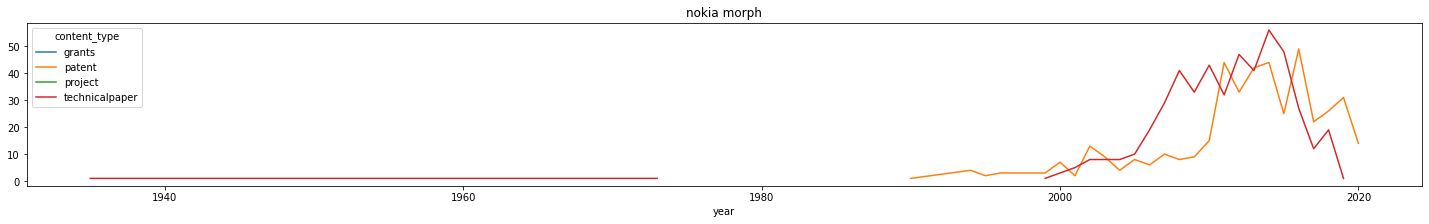

In [185]:
plt.rcParams["figure.figsize"] = (25,3)

for q in sample(queries, 1):
  df[df['query'] == q].plot(x = 'year', title = q)

In [186]:
df.to_csv('/content/drive/MyDrive/PISCHOOL/queries_wiki_dataset.csv', index=False)